
<center><img src="https://www.thames21.org.uk/wp-content/uploads/2014/11/Grey-Street.jpg"></center>


### Introduction

<a href="https://en.wikipedia.org/wiki/Urban_runoff">Urban runoff</a> is surface runoff of rainwater created by urbanization. This runoff is a major source of flooding and water pollution in urban communities worldwide.

During rain storms and other precipitation events, concrete, asphalt and other surfaces carry polluted stormwater to storm drains, instead of allowing the water to percolate through soil. This causes lowering of the water table (because groundwater recharge is lessened) and flooding since the amount of water that remains on the surface is greater. Most municipal storm sewer systems discharge stormwater, untreated, to streams, rivers and bays. This excess water can also make its way into people's properties through basement backups and seepage through building wall and floors.

In this notebook you will use *FNNs*, *SimpleRNNs*, as well as *LSTMs* to predict whether a certain storm event will result in flooding of an Urban area. The original input sequences are events of different length sampled at 5 minutes time resolution; the output is a binary variable which is equal to 1 in case flooding has occurred as a consequence of the storm. It's important to note that the drainage system is supposed to be empty before the storm (otherwise we would have needed more variable to make reliable predictions, e.g. the amount of water already stored in the storage system).

Which type of ANN will provide better prediction performances? 

#### Link with Google Drive and load modules

In [1]:
# link to Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

Mounted at /content/gdrive
'My Drive'


In [2]:
# generic modules
import datetime, os
import itertools
import time
import pickle

# append working folder
import sys
working_folder = './gdrive/My Drive/Teaching/CS4305TU Applied Machine Learning/SWMM/'
sys.path.append(working_folder)


# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import backend as K

# sklearn helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#### Load dataset (using Python <a href="https://docs.python.org/3/library/pickle.html">pickle</a>)

In [3]:
# load dataset
filename = 'SWMM_FloodNoFlood.pickle'
with open(working_folder+filename, 'rb') as handle:
    dataset = pickle.load(handle)
print(dataset.keys())
n_episodes = len(dataset['input'])
print(f"{n_episodes} episodes in the dataset")

dict_keys(['input', 'output'])
314 episodes in the dataset


#### Visualize events

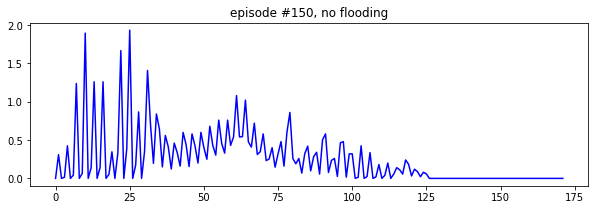

In [12]:
# let's visualize some events
# choose random seed
np.random.seed(31233)

# initialize figure with subplots
f, ax = plt.subplots(1,figsize=(10,3))

# select episode
episode_num = np.random.choice(len(dataset['input']))
rainfall = dataset['input'][episode_num]
flooding = dataset['output'][episode_num]

# plot
ax.plot(rainfall, lw=1.5, color='blue');
if flooding == True:
  ax.set_title(f'episode #{episode_num:03d}, FLOODING')
else:
  ax.set_title(f'episode #{episode_num:03d}, no flooding')


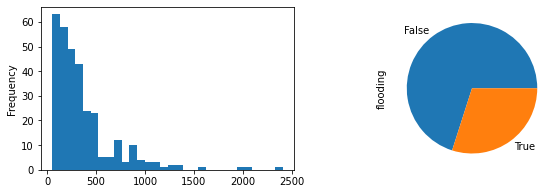

In [9]:
# cycle through all episodes, store length of sequence and flooding
df = pd.DataFrame(columns=['seq_length','flooding'])
for i in np.arange(n_episodes):
  df.loc[i,['seq_length','flooding']] = len(dataset['input'][i]), dataset['output'][i]

# plot input and output distributoin
f, axes = plt.subplots(1,2,figsize=(10,3));

# plot distribution of seq_length
df.seq_length.plot(kind='hist',bins=30, ax=axes[0]);

# print distribution of flooding column
df.flooding.value_counts().plot(kind='pie', ax=axes[1]);



#### Reduce dataset

In [6]:
# reduce original dataset
episodes_to_keep = df[df.seq_length<=500].index.tolist()

# create dataset
X, Y = [], []
for episode in episodes_to_keep:
  X.append(dataset['input'][episode].reshape(-1))
  Y.append(dataset['output'][episode].astype(int))

# transform X and Y in array
X = np.array(X)
Y = np.array(Y)

# tra = training, val = validation (early stopping), test = testing (unseen)
T = df.loc[episodes_to_keep].seq_length.max() # max sequence length
print(f'The longest rainfall event lasts {T} timesteps (5 minutes)')


The longest rainfall event lasts 496 timesteps (5 minutes)


#### Pad input sequences to reach the same length

In [7]:
# padding sequences in keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = [[1], [2, 3], [4, 5, 6]]
print(sequences)
print(pad_sequences(sequences, maxlen=4))

[[1], [2, 3], [4, 5, 6]]
[[0 0 0 1]
 [0 0 2 3]
 [0 4 5 6]]


In [8]:
print(len(X[0]))
X = pad_sequences(X, maxlen=T, dtype='float64')
print(len(X[0]))
print(X[0])

100
496
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

#### Create final datasets

In [9]:
Xtra,Xval,Ytra,Yval = train_test_split(X,Y,test_size=0.20,stratify=Y,random_state=42)

print(f"Training: \tX.shape: {Xtra.shape}, \tY.shape: {Ytra.shape}")
print(f"Validation:\tX.shape: {Xval.shape}, \tY.shape: {Yval.shape}")

# IMPORTANT: we have little data so we are not using a test dataset! 
# The validation is used for early stopping, so it is not a real test dataset.

Training: 	X.shape: (201, 496), 	Y.shape: (201,)
Validation:	X.shape: (51, 496), 	Y.shape: (51,)


#### Craete and train several models

In [ ]:
# Function for model creation
def FNNmodel(n_hidden_neurons=10, dropout_rate=0.1):
  i = Input(shape=(T,))      
  x = Dense(neurons, activation='sigmoid', name='Hidden_layer')(i)
  x = Dropout(dropout_rate)(x)
  x = Dense(1, activation='sigmoid', name='Output')(x)  
  model = Model(i,x)
  return model

def RNNmodel(n_hidden_neurons=10, cell_type='LSTM', dropout_rate=0.2):
  i = Input(shape=(T,1))
  if cell_type == 'SimpleRNN':
      x = SimpleRNN(n_hidden_neurons, activation='tanh', return_sequences=False, name='SimpleRNN')(i)
  elif cell_type == 'LSTM':
      x = LSTM(n_hidden_neurons, activation='tanh', name='LSTM')(i)
  else:
    raise Exception("Error: Cell type not recognized! Choose between 'SimpleRNN','LSTM', or 'GRU'.")    
  x = Dropout(dropout_rate)(x)
  x = Dense(1, activation='sigmoid', name='Output')(x)
  model = Model(i,x)
  return model

In [ ]:
# create model combinations (using itertools product)
ANN_type = ['FNN','SimpleRNN','LSTM']
neurons = [10,25]
dropout_rate = [0,0.25]
lr = [0.0001]
batch_size = [16]

all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,lr,batch_size]))
print(pd.DataFrame(data=all_combinations, columns=['ann_type','neurons','dropout_rate','lr','batch_size']))

     ann_type  neurons  dropout_rate      lr  batch_size
0         FNN       10          0.00  0.0001          16
1         FNN       10          0.25  0.0001          16
2         FNN       25          0.00  0.0001          16
3         FNN       25          0.25  0.0001          16
4   SimpleRNN       10          0.00  0.0001          16
5   SimpleRNN       10          0.25  0.0001          16
6   SimpleRNN       25          0.00  0.0001          16
7   SimpleRNN       25          0.25  0.0001          16
8        LSTM       10          0.00  0.0001          16
9        LSTM       10          0.25  0.0001          16
10       LSTM       25          0.00  0.0001          16
11       LSTM       25          0.25  0.0001          16


In [10]:
# result df 
res_df_rnn = pd.DataFrame(index=np.arange(len(all_combinations)), 
                      columns=['ann_type','neurons','dropout_rate','lr','batch_size','model_name',
                               'tr_loss','val_loss','tr_acc','val_acc','val_f1score','elapsed_time','trainable_params'])

rs = [] # histories

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, dropout_rate, lr, batch_size = combination
  model_name = f"{ANN_type}_neurons={neurons}_dropout={dropout_rate}_lr={lr}_bsize={batch_size}"
  # store in res_df 
  res_df_rnn.loc[i,['ann_type','neurons', 'dropout_rate','lr','batch_size','model_name']] = combination + (model_name,)

  # call backs
  earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=1e-6, mode='auto')
  modelCheckpoint = ModelCheckpoint(f'{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
  timeStopping = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)  
  callbacks = [earlyStopping, modelCheckpoint, timeStopping]

  # create model
  if ANN_type == 'FNN':
    model = FNNmodel(neurons, dropout_rate=dropout_rate)
  else:
    model = RNNmodel(neurons, cell_type=ANN_type, dropout_rate=dropout_rate)

  # compile
  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=lr), metrics=['accuracy'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')
  # train
  start_time = time.time()
  r = model.fit(Xtra, Ytra,epochs=200,validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=batch_size)
  # append history
  rs.append(r)
  # store results
  res_df_rnn.loc[i,'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_rnn.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix],
                                                                 r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]     
  res_df_rnn.loc[i,'trainable_params'] = get_trainable_params(model)
  # load weights and compute f1_score
  model.load_weights(f'{model_name}.hdf5')
  Yval_pred = (model.predict(Xval)>0.5).astype(int).reshape(-1)
  res_df_rnn.loc[i,['val_f1score']] = f1_score(Yval,Yval_pred)
  print(res_df_rnn.loc[i,['elapsed_time','val_loss','val_acc','val_f1score']])

#### Compare the results

In [ ]:
res_df_rnn.sort_values(by='val_loss')

,ann_type,neurons,dropout_rate,lr,batch_size,model_name,tr_loss,val_loss,tr_acc,val_acc,val_f1score,elapsed_time,trainable_params
10,LSTM,25,0,0.0001,16,LSTM_neurons=25_dropout=0_lr=0.0001_bsize=16,0.29264,0.198214,0.890547,0.960784,0.916667,190.563,2726
11,LSTM,25,0.25,0.0001,16,LSTM_neurons=25_dropout=0.25_lr=0.0001_bsize=16,0.391369,0.376757,0.781095,0.764706,0,189.637,2726
9,LSTM,10,0.25,0.0001,16,LSTM_neurons=10_dropout=0.25_lr=0.0001_bsize=16,0.464616,0.443024,0.766169,0.764706,0,180.773,491
6,SimpleRNN,25,0,0.0001,16,SimpleRNN_neurons=25_dropout=0_lr=0.0001_bsize=16,0.536079,0.534016,0.766169,0.764706,0,300.666,701
7,SimpleRNN,25,0.25,0.0001,16,SimpleRNN_neurons=25_dropout=0.25_lr=0.0001_bs...,0.544813,0.54544,0.766169,0.764706,0,303.906,701
8,LSTM,10,0,0.0001,16,LSTM_neurons=10_dropout=0_lr=0.0001_bsize=16,0.542761,0.545633,0.766169,0.764706,0,181.34,491
2,FNN,25,0,0.0001,16,FNN_neurons=25_dropout=0_lr=0.0001_bsize=16,0.457661,0.551858,0.825871,0.803922,0.285714,6.74984,12451
1,FNN,10,0.25,0.0001,16,FNN_neurons=10_dropout=0.25_lr=0.0001_bsize=16,0.435033,0.559403,0.860696,0.745098,0.235294,14.3949,4981
3,FNN,25,0.25,0.0001,16,FNN_neurons=25_dropout=0.25_lr=0.0001_bsize=16,0.514701,0.564566,0.766169,0.764706,0,4.8671,12451
5,SimpleRNN,10,0.25,0.0001,16,SimpleRNN_neurons=10_dropout=0.25_lr=0.0001_bs...,0.584218,0.566075,0.761194,0.764706,0,302.984,131


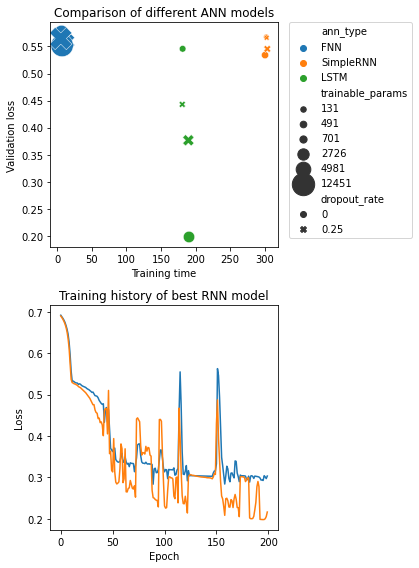

In [ ]:
f, axes = plt.subplots(2,1,figsize=(6,8))
sns.scatterplot(
    data=res_df_rnn, x="elapsed_time", y="val_loss", hue="ann_type", style="dropout_rate", size="trainable_params", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different ANN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

best_model_ix = res_df_rnn['val_loss'].astype(float).idxmin();
axes[1].plot(rs[best_model_ix].history['loss'],label='Training loss');
axes[1].plot(rs[best_model_ix].history['val_loss'],label='Validation loss');
axes[1].set_title('Training history of best RNN model');
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
f.tight_layout()